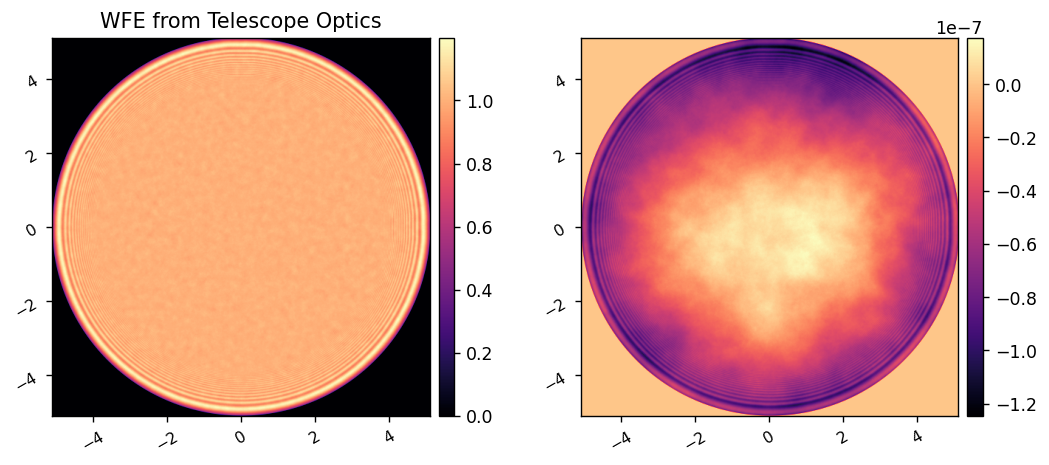

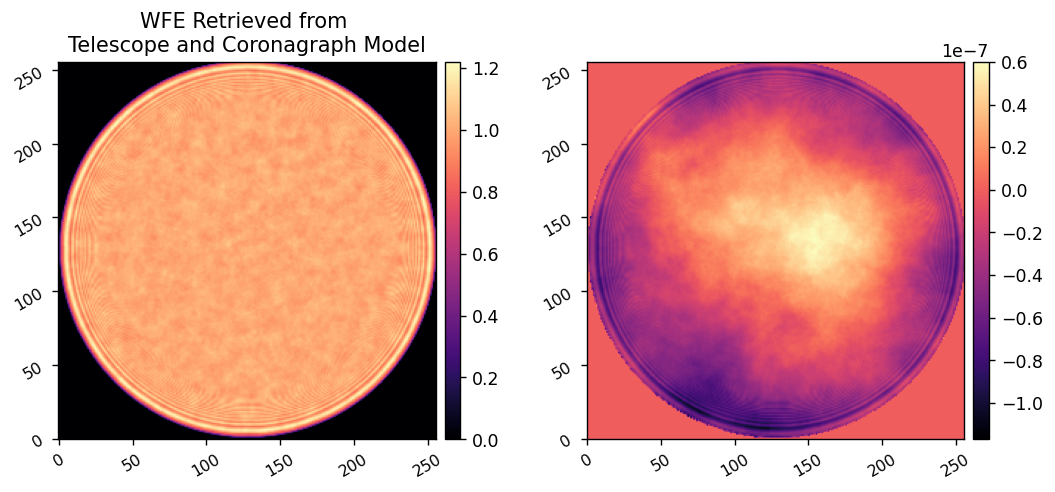

In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
xp = cp if poppy.accel_math._USE_CUPY else np

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from prop_models import full, compact, agpm
reload(full)
reload(compact)
reload(agpm)

from wfsc_1dm import efc, pwp, utils
from imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 750e-9*u.m

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

lyot_stop_physical = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm)
lyot_stop_compact = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm * 500/350)

# hdr = fits.getheader('wfe_on_axis.fits')
# ote_wfe = poppy.FITSOpticalElement(opd='wfe_on_axis.fits', opdunits='meters',
#                                    pixelscale=pupil_diam.to_value(u.m)/hdr['NAXIS1'])
# imshow1(ote_wfe.opd, 'WFE from Telescope Optics', pxscl=ote_wfe.pixelscale.to(u.mm/u.pix))

# Load in the OTE WFE for the full model of the coronagraph
ote_wfe_fname = 'ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE.amplitude, OTE_WFE.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE.pixelscale.to(u.mm/u.pix))


# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('phase-retrieval-data/pre_fpm_pupil_wfe.fits')
coro_wfe = wfe_fits[0].data
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1],pixelscale=wfe_pxscl,)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 'WFE Retrieved from \nTelescope and Coronagraph Model')

# Test the match between the full model and the compact model

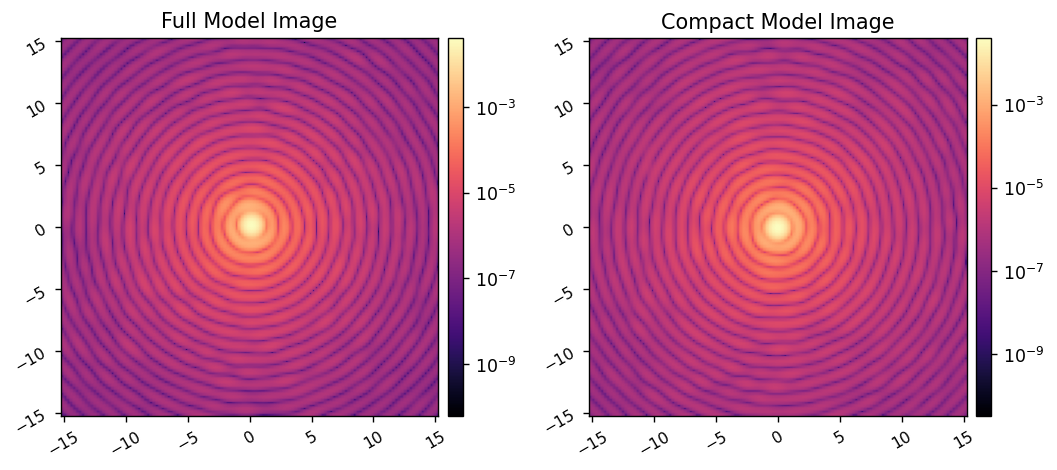

In [2]:
reload(full)
reload(compact)

reload(agpm)
vortexf = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
vortexc = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

fc = full.CORO()
fc.npix = 256
fc.oversample = 16
fc.npsf = 128
fc.use_opds = True
fc.OTEWFE = OTE_WFE

cc = compact.CORO()
cc.npix = 256
cc.oversample = 16
cc.npsf = 128
cc.RETRIEVED = CORO_WFE

ref_psf_full = fc.snap()
ref_psf_comp = cc.snap()

imshow2(ref_psf_full, ref_psf_comp, 'Full Model Image', 'Compact Model Image', lognorm=True,
             pxscl1=fc.psf_pixelscale_lamD, pxscl2=cc.psf_pixelscale_lamD)

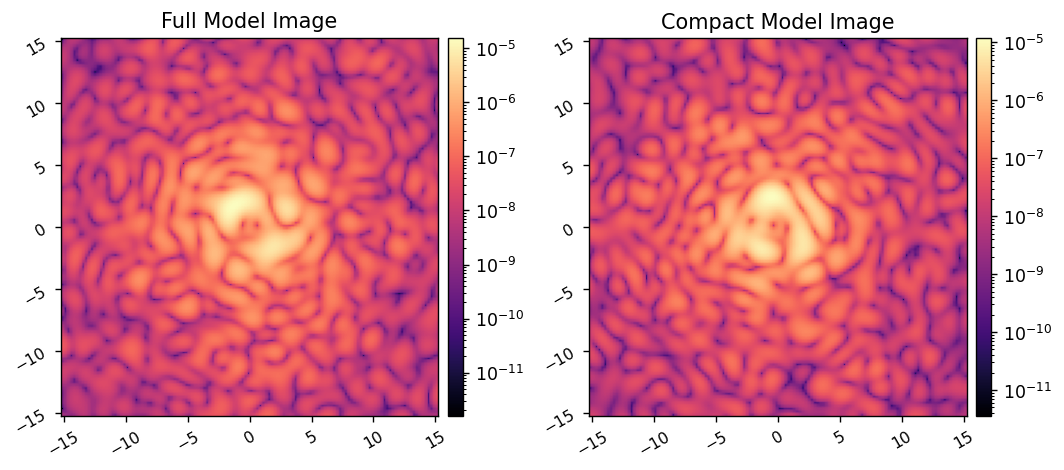

In [3]:
fc.FPM = vortexf
fc.LYOT = lyot_stop_physical

cc.FPM = vortexc
cc.LYOT = lyot_stop_compact

ref_im_full = fc.snap()
ref_im_comp = cc.snap()

imshow2(ref_im_full, ref_im_comp, 'Full Model Image', 'Compact Model Image', lognorm=True,
             pxscl1=fc.psf_pixelscale_lamD, pxscl2=cc.psf_pixelscale_lamD)

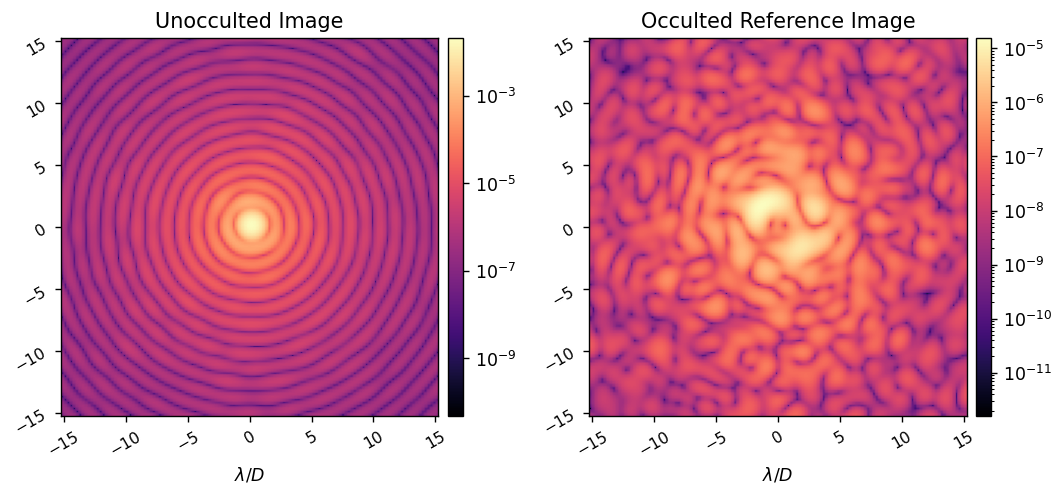

In [5]:
reload(full)

fc.FPM = None
ref_im_unocc = fc.snap()

fc.FPM = vortexf
ref_im = fc.snap()

imshow2(ref_im_unocc, ref_im, 'Unocculted Image', 'Occulted Reference Image',
        lognorm=True, pxscl=fc.psf_pixelscale_lamD, xlabel='$\lambda/D$')

In [13]:
type(ref_im)

numpy.ndarray

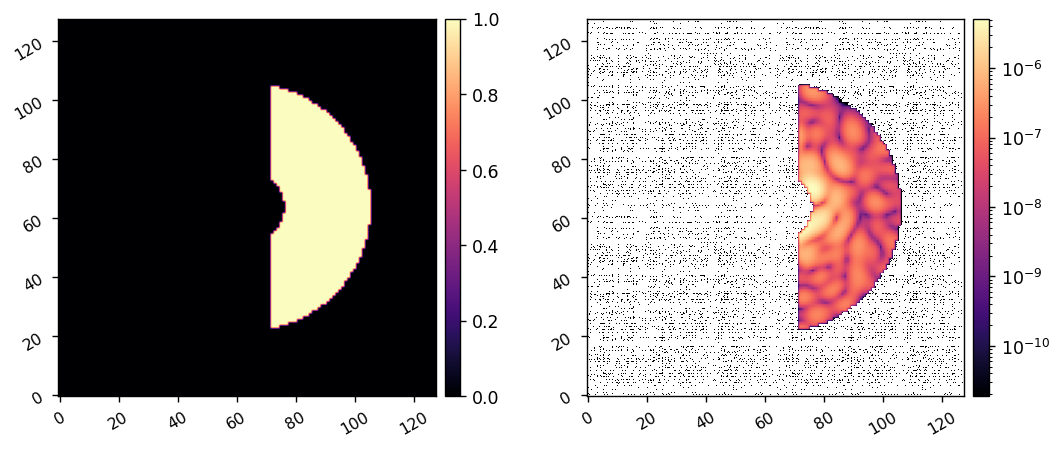

Saved data to:  masks\dark_mask.fits


In [6]:
reload(utils)
npsf = cc.npsf
nact = cc.Nact

xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*cc.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 10
rot = 0

# Create the mask that is used to select which region to make dark.
dark_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
    'full': False
}
dark_mask = utils.create_annular_focal_plane_mask(fpx, fpy, dark_params)
imshow2(dark_mask, dark_mask*ref_im, lognorm2=True)

utils.save_fits('masks\dark_mask.fits', dark_mask.astype(np.int32))

In [11]:
reload(efc)

cc.reset_dm()
epsilon = 1e-9 # poke amplitudes (DM surface)
jac = efc.build_jacobian(cc, epsilon, dark_mask.flatten(), display=False)

	Calculated response for mode 1/952. Elapsed time=0.667 sec.
	Calculated response for mode 2/952. Elapsed time=0.941 sec.
	Calculated response for mode 3/952. Elapsed time=1.214 sec.
	Calculated response for mode 4/952. Elapsed time=1.510 sec.
	Calculated response for mode 5/952. Elapsed time=1.780 sec.
	Calculated response for mode 6/952. Elapsed time=2.053 sec.
	Calculated response for mode 7/952. Elapsed time=2.329 sec.
	Calculated response for mode 8/952. Elapsed time=2.600 sec.
	Calculated response for mode 9/952. Elapsed time=2.870 sec.
	Calculated response for mode 10/952. Elapsed time=3.144 sec.
	Calculated response for mode 11/952. Elapsed time=3.415 sec.
	Calculated response for mode 12/952. Elapsed time=3.687 sec.


KeyboardInterrupt: 

In [15]:
import misc_funs as misc
misc.save_fits('jacobians\jacobian_20230606.fits', jac, header={'NACTS':952, 'NMASK':int(dark_mask.sum())})

Saved data to:  jacobians\jacobian_20230606.fits


In [7]:
jac = xp.array(fits.getdata('jacobians\jacobian_2023060.fits'))
print(jac.shape, jac.size)

(4084, 952) 3887968


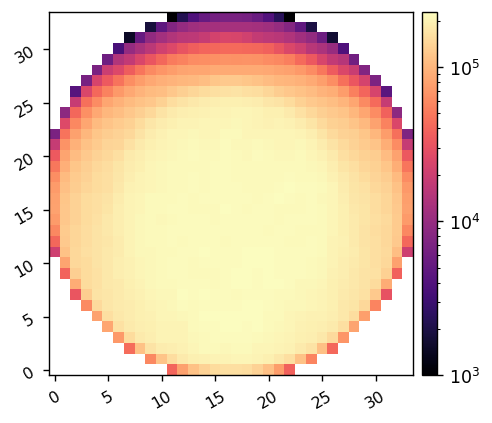

In [8]:
reload(utils)
response = utils.map_acts_to_dm(xp.sqrt(((jac)**2).sum(axis=0)), cc.dm_mask)
imshow1(response, lognorm=True, vmin=1e3)

In [13]:
reload(utils)
control_matrix = utils.beta_reg(jac, beta=-2)

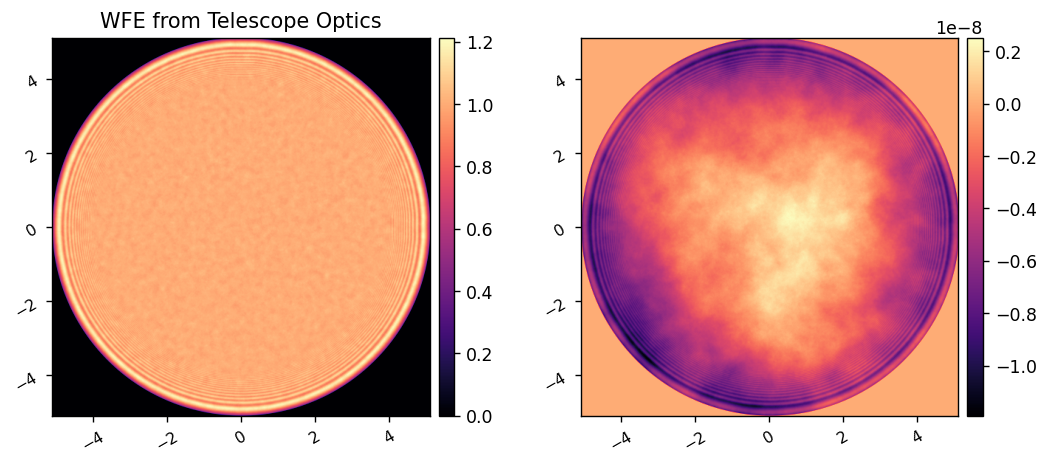

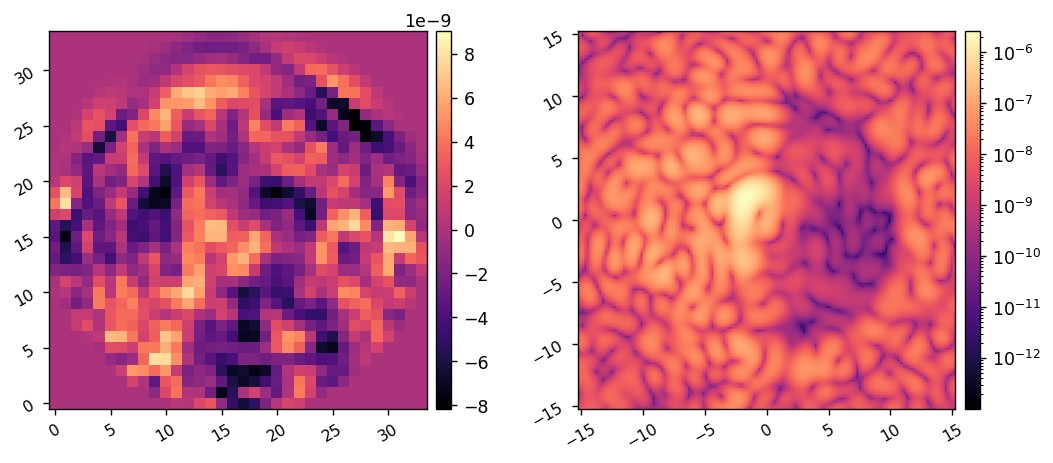

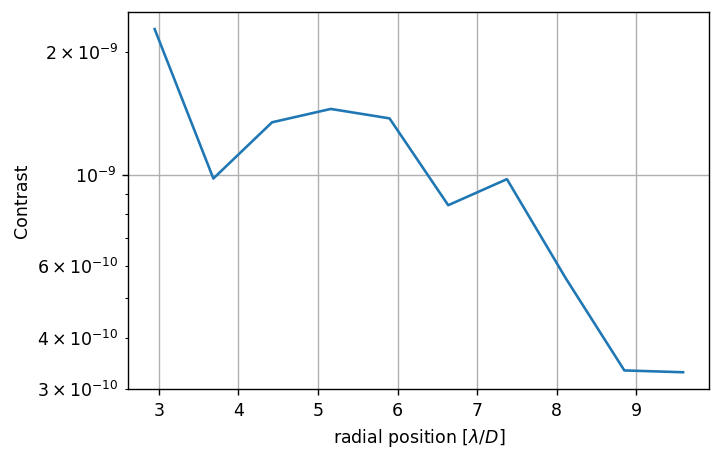

In [21]:
reload(efc)
reload(utils)
fc.reset_dm()

dm_command = fc.get_dm()

efc_loop_gain = 0.5

Niter = 30
for i in range(Niter):
    ote_wfe_fname = 'ote-wfe-data/telescope_wfe_{:d}.fits'.format(i)
    wfe_hdu = fits.open(ote_wfe_fname)
    wfe = xp.array(wfe_hdu[0].data)
    wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
    wfe_hdu.close()
    OTE_WFE = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1]/10, pixelscale=wfe_pxscl,)
    imshow2(OTE_WFE.amplitude, OTE_WFE.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE.pixelscale.to(u.mm/u.pix))

    fc.OTEWFE = OTE_WFE
    
    electric_field = fc.calc_psf() # not using PWP for E-field estimation
    im = xp.abs(electric_field)**2
    
    del_dm = efc.single_iteration(electric_field, control_matrix, dark_mask, fc.dm_mask)
    dm_command += efc_loop_gain*del_dm
    fc.set_dm(dm_command)
    
    imshow2(dm_command, im, 
            lognorm2=True, pxscl2=fc.psf_pixelscale_lamD)
    utils.plot_radial_contrast(im, dark_mask, fc.psf_pixelscale_lamD, nbins=30)
    clear_output(wait=True)